# Diabetes Prediction via a Regression Analysis

* By. Gukhwan Hyun

# Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
import scipy.stats

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
# path_to_zip_file = '/content/drive/MyDrive/Data Science/국민건강보험공단_건강검진정보_20201231.zip'
# directory_to_extract_to = '/content/drive/MyDrive/Data Science/physicals'

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

# Load the dataset
  * skipped a single data due to an error

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Data Science/physicals/SCR_2019_1백만20210119수정.csv', 
                      encoding='cp949',
                      error_bad_lines=False)
dataset

b'Skipping line 175683: expected 34 fields, saw 36\n'


,기준년도,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,이완기 혈압,식전혈당(공복혈당),총 콜레스테롤,트리글리세라이드,HDL 콜레스테롤,LDL 콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,결손치 유무,치아마모증유무,제3대구치(사랑니) 이상,치석,데이터 공개일자
0,2019,1,11,1,13,165,65,90.0,1.5,1.2,1.0,1.0,112.0,70.0,93.0,NaN,NaN,NaN,NaN,15.5,1.0,1.0,18.0,32.0,47.0,2.0,NaN,1,0.0,미시행,미시행,미시행,1.0,2019-12-31
1,2019,2,48,2,5,155,45,64.0,1.2,0.5,1.0,1.0,114.0,76.0,89.0,NaN,NaN,NaN,NaN,14.0,1.0,0.5,15.0,8.0,13.0,1.0,1.0,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
2,2019,3,41,1,13,160,70,87.0,0.9,0.8,1.0,1.0,109.0,73.0,100.0,232.0,114.0,57.0,152.0,15.6,1.0,1.0,30.0,21.0,17.0,1.0,1.0,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
3,2019,4,28,1,12,170,60,85.0,0.4,1.2,1.0,1.0,131.0,85.0,85.0,NaN,NaN,NaN,NaN,14.5,1.0,0.7,17.0,19.0,32.0,2.0,1.0,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
4,2019,5,41,1,10,170,70,81.2,0.7,0.7,1.0,1.0,112.0,66.0,91.0,NaN,NaN,NaN,NaN,14.9,1.0,0.9,19.0,24.0,19.0,2.0,NaN,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063613,2019,999996,41,1,12,170,65,80.0,1.0,1.2,1.0,1.0,116.0,79.0,129.0,NaN,NaN,NaN,NaN,15.7,1.0,1.3,24.0,23.0,21.0,1.0,1.0,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
1063614,2019,999997,11,1,9,170,55,75.0,0.9,0.8,1.0,1.0,99.0,61.0,130.0,157.0,50.0,54.0,93.0,15.4,2.0,0.9,16.0,15.0,27.0,2.0,1.0,0,NaN,미시행,미시행,미시행,NaN,2019-12-31
1063615,2019,999998,45,1,13,160,65,92.3,1.0,0.9,1.0,1.0,116.0,70.0,102.0,NaN,NaN,NaN,NaN,15.9,1.0,1.0,23.0,28.0,84.0,2.0,1.0,1,0.0,미시행,미시행,미시행,0.0,2019-12-31
1063616,2019,999999,30,1,8,170,75,85.0,0.8,0.8,1.0,1.0,112.0,71.0,89.0,NaN,NaN,NaN,NaN,15.3,1.0,1.0,25.0,65.0,29.0,2.0,1.0,1,0.0,미시행,미시행,미시행,0.0,2019-12-31


# Preprocessing

In [ ]:
diabetes = dataset.copy()

In [ ]:
diabetes.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063618 entries, 0 to 1063617
Data columns (total 34 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   기준년도           1063618 non-null  int64  
 1   가입자 일련번호       1063618 non-null  int64  
 2   시도코드           1063618 non-null  int64  
 3   성별코드           1063618 non-null  int64  
 4   연령대 코드(5세단위)   1063618 non-null  int64  
 5   신장(5Cm단위)      1063618 non-null  int64  
 6   체중(5Kg 단위)     1063618 non-null  int64  
 7   허리둘레           1063195 non-null  float64
 8   시력(좌)          1063411 non-null  float64
 9   시력(우)          1063418 non-null  float64
 10  청력(좌)          1063427 non-null  float64
 11  청력(우)          1063430 non-null  float64
 12  수축기 혈압         1057819 non-null  float64
 13  이완기 혈압         1057818 non-null  float64
 14  식전혈당(공복혈당)     1057714 non-null  float64
 15  총 콜레스테롤        354892 non-null   float64
 16  트리글리세라이드       354887 non-null   float64
 17  HDL 콜레스테

## Elimination
  *  Irrelevant infos
  *  Missing values

In [ ]:
diabetes.drop(columns=['기준년도', '가입자 일련번호', '구강검진 수검여부', '총 콜레스테롤', '트리글리세라이드', '음주여부',
                       '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '허리둘레',
                       '청력(좌)', '청력(우)','HDL 콜레스테롤', 'LDL 콜레스테롤', '치아우식증유무','치아마모증유무',
                       '결손치 유무', '제3대구치(사랑니) 이상', '치석', '데이터 공개일자'], inplace=True)

In [ ]:
diabetes.dropna(inplace=True)

In [ ]:
diabetes.reset_index(inplace=True)

In [ ]:
diabetes.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052215 entries, 0 to 1052214
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   index         1052215 non-null  int64  
 1   시도코드          1052215 non-null  int64  
 2   성별코드          1052215 non-null  int64  
 3   연령대 코드(5세단위)  1052215 non-null  int64  
 4   신장(5Cm단위)     1052215 non-null  int64  
 5   체중(5Kg 단위)    1052215 non-null  int64  
 6   시력(좌)         1052215 non-null  float64
 7   시력(우)         1052215 non-null  float64
 8   수축기 혈압        1052215 non-null  float64
 9   이완기 혈압        1052215 non-null  float64
 10  식전혈당(공복혈당)    1052215 non-null  float64
 11  혈색소           1052215 non-null  float64
 12  요단백           1052215 non-null  float64
 13  감마 지티피        1052215 non-null  float64
 14  흡연상태          1052215 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 120.4 MB


## Categorization, Factorization
  * 시도코드, 성별코드, 흡연상태 --> 이름
  * 연령대 --> 10살 단위

In [ ]:
#pd.Series(diabetes['시도코드'].unique()).sort_values()

In [ ]:
diabetes['시도코드'] = diabetes['시도코드'].astype(str)

In [ ]:
diabetes['시도코드'].replace(to_replace=['11', '26', '27', '28', '29', '30', '31', '36', '41', '42', '43', '44', '45', '46', '47', '48', '50'],
                           value = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시','대전광역시', '울산광역시', 
                              '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도','전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도'],
                         inplace=True)


In [ ]:
#diabetes['시도코드'].value_counts()

In [ ]:
diabetes['성별코드'].replace(to_replace=[1,2],
                         value=['Male', 'Female'],
                         inplace=True)

In [ ]:
diabetes['요단백'].value_counts()

1.0    984949
2.0     38176
3.0     19479
4.0      6802
5.0      2206
6.0       603
Name: 요단백, dtype: int64

In [ ]:
diabetes['요단백'] = diabetes['요단백'].astype(str)

In [ ]:
diabetes['흡연상태'].value_counts()

1.0    662225
2.0    389990
Name: 흡연상태, dtype: int64

In [ ]:
diabetes['흡연상태'].replace(to_replace=[1.0, 2.0],
                         value = ['Smoker', 'Non-smoker'],
                         inplace=True)

In [ ]:
diabetes['연령대 코드(5세단위)'].unique()

array([13,  5, 12, 10,  8,  6, 14, 11, 16,  9,  7, 18, 15, 17])

5,6 20s

7,8 30s
  
9,10 40s

11,12 50s

13,14 60s

15,16 70s

17~ over80s

In [ ]:
diabetes['Age group'] = pd.cut(diabetes['연령대 코드(5세단위)'],
       bins=list(range(4, 20, 2)),
       labels= ['20s', '30s', '40s', '50s', '60s', '70s','over80s'])

## Feature Engineering
  * 키, 몸무게 --> BMI
  * 시력 좌우 평균 
  * 수축기혈압, 이완기혈압 --> 고혈압

In [ ]:
def bmi_calculator(height_data, weight_data):
  bmi = []
  for height, weight in zip(height_data, weight_data):
    val = weight / ((height/100)**2)
    val = round(val, 1)
    bmi.append(val)
  return pd.DataFrame(bmi)

In [ ]:
diabetes['BMI'] = bmi_calculator(diabetes['신장(5Cm단위)'].values, diabetes['체중(5Kg 단위)'].values)

In [ ]:
def avg_eyesight(left, right):
  eyesights = []
  for l,r in zip(left, right):
    eyesight = (l+r)/2
    eyesights.append(eyesight)
  return pd.DataFrame(eyesights)

In [ ]:
diabetes['평균시력'] = avg_eyesight(diabetes['시력(좌)'].values, diabetes['시력(우)'].values)

In [ ]:
def blood_pressure(compressed, decompressed):
  bps = []
  for c,u in zip(compressed, decompressed):
    if c >= 140 and u >=90:
      bps.append('Hypertension')
    else:
      bps.append('Normal')
  return pd.DataFrame(bps)

In [ ]:
diabetes['고혈압'] = blood_pressure(diabetes['수축기 혈압'].values, diabetes['이완기 혈압'].values)

# EDA

In [ ]:
eda = diabetes.drop(columns=['index','연령대 코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '시력(좌)', '시력(우)', '수축기 혈압', '이완기 혈압'])
eda

,시도코드,성별코드,식전혈당(공복혈당),혈색소,요단백,감마 지티피,흡연상태,Age group,BMI,평균시력,고혈압
0,서울특별시,Male,93.0,15.5,1.0,47.0,Non-smoker,60s,23.9,1.35,Normal
1,경상남도,Female,89.0,14.0,1.0,13.0,Smoker,20s,18.7,0.85,Normal
2,경기도,Male,100.0,15.6,1.0,17.0,Smoker,60s,27.3,0.85,Normal
3,인천광역시,Male,85.0,14.5,1.0,32.0,Non-smoker,50s,20.8,0.80,Normal
4,경기도,Male,91.0,14.9,1.0,19.0,Non-smoker,40s,24.2,0.70,Normal
...,...,...,...,...,...,...,...,...,...,...,...
1052210,경기도,Male,129.0,15.7,1.0,21.0,Smoker,50s,22.5,1.10,Normal
1052211,서울특별시,Male,130.0,15.4,2.0,27.0,Non-smoker,40s,19.0,0.85,Normal
1052212,전라북도,Male,102.0,15.9,1.0,84.0,Non-smoker,60s,25.4,0.95,Normal
1052213,대전광역시,Male,89.0,15.3,1.0,29.0,Non-smoker,30s,26.0,0.80,Normal


In [ ]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052215 entries, 0 to 1052214
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   시도코드        1052215 non-null  object  
 1   성별코드        1052215 non-null  object  
 2   식전혈당(공복혈당)  1052215 non-null  float64 
 3   혈색소         1052215 non-null  float64 
 4   요단백         1052215 non-null  object  
 5   감마 지티피      1052215 non-null  float64 
 6   흡연상태        1052215 non-null  object  
 7   Age group   1052215 non-null  category
 8   BMI         1052215 non-null  float64 
 9   평균시력        1052215 non-null  float64 
 10  고혈압         1052215 non-null  object  
dtypes: category(1), float64(5), object(5)
memory usage: 81.3+ MB


In [ ]:
eda.corr()

,식전혈당(공복혈당),혈색소,감마 지티피,BMI,평균시력
식전혈당(공복혈당),1.000000,0.106847,0.167481,0.178013,-0.049863
혈색소,0.106847,1.000000,0.228802,0.263183,0.101847
감마 지티피,0.167481,0.228802,1.000000,0.173534,0.017464
BMI,0.178013,0.263183,0.173534,1.000000,0.013058
평균시력,-0.049863,0.101847,0.017464,0.013058,1.000000


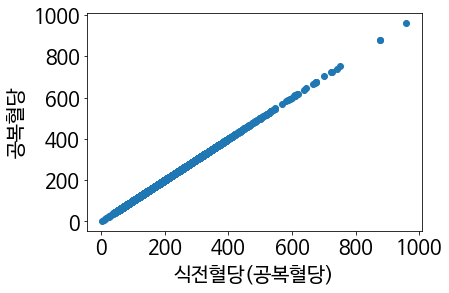

****************************************************************************************************


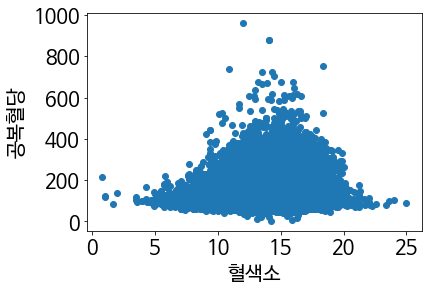

****************************************************************************************************


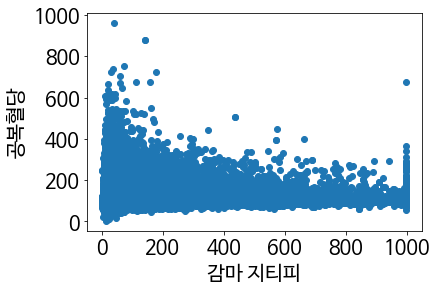

****************************************************************************************************


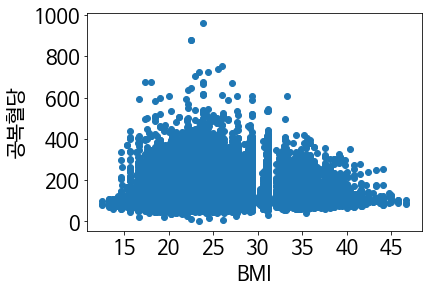

****************************************************************************************************


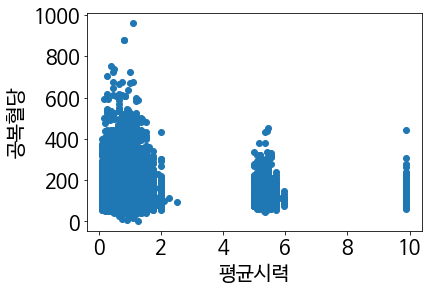

****************************************************************************************************


In [ ]:
for col in list(eda.corr().columns):
  plt.scatter(diabetes[col], diabetes['식전혈당(공복혈당)'])
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.ylabel("공복혈당",fontsize=20)
  plt.xlabel(col,fontsize=20)
  plt.show()
  print('*'*100)

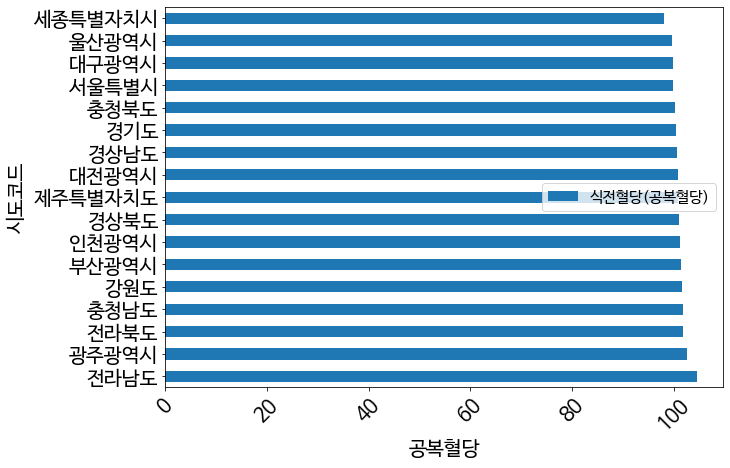

****************************************************************************************************


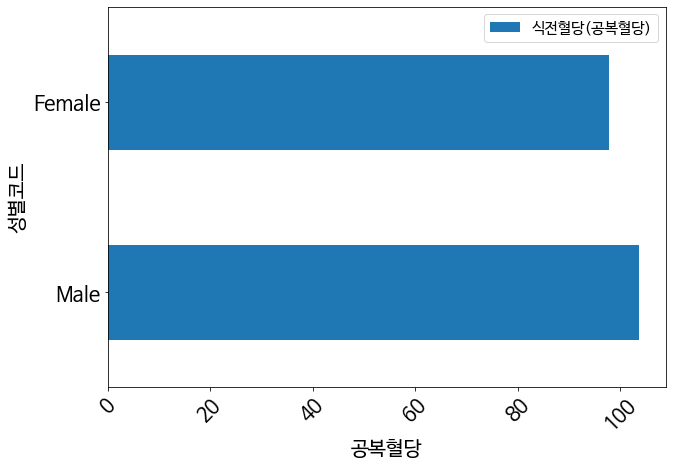

****************************************************************************************************


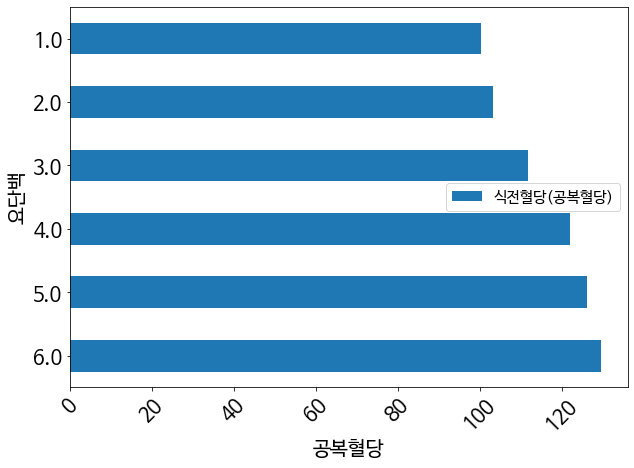

****************************************************************************************************


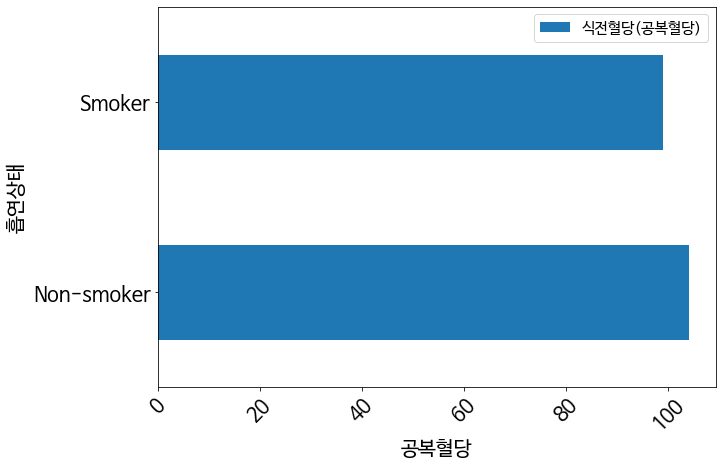

****************************************************************************************************


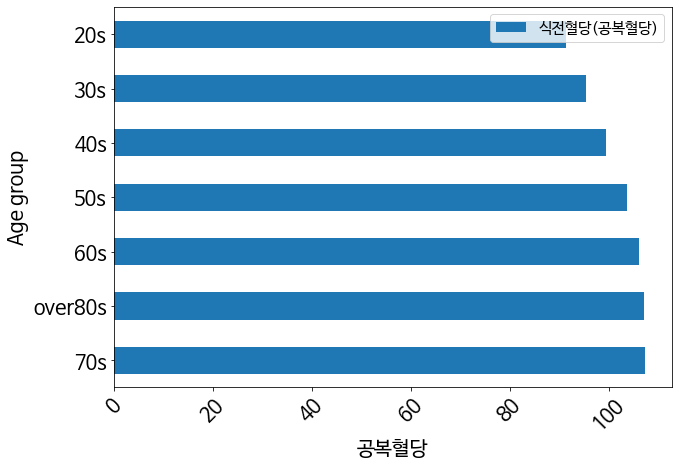

****************************************************************************************************


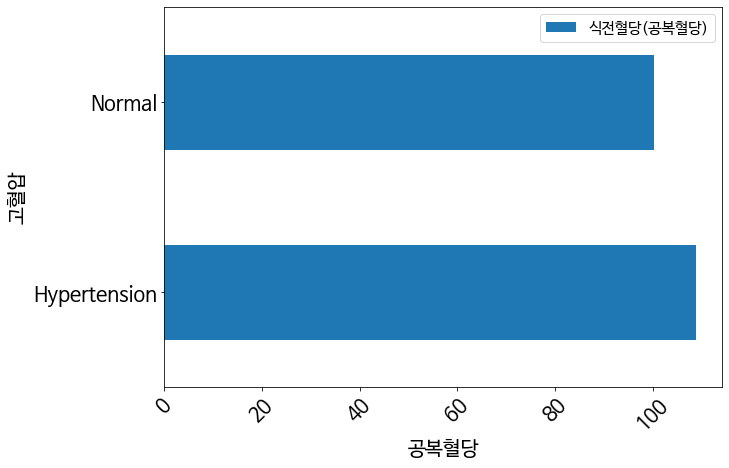

****************************************************************************************************


In [ ]:
for col in list(eda.columns):
  if col not in list(eda.corr().columns):
    diabetes.groupby(col)['식전혈당(공복혈당)'].mean().sort_values(ascending=False).plot(kind='barh', figsize=(10,7))
    plt.xticks(rotation=45, fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("공복혈당",fontsize=20)
    plt.ylabel(col,fontsize=20)
    plt.legend(fontsize=15)
    plt.show()
    print('*'*100)

# Regression Analysis

In [ ]:
a = eda.rename(columns={'시도코드' : 'Region',
                    '성별코드' : "Gender", 
                    '식전혈당(공복혈당)' : "Fasting_Blood_Sugar",
                    '혈색소' : "Hemoglobin",
                    '요단백' : "Proteinuria",
                    '감마 지티피' : "Gamma_GTP",
                    '흡연상태' : 'Smoke',
                    '평균시력' : 'Avg_Eyesight',
                    '고혈압' : 'Blood_pressure'})

## 사전작업

독립변수, 종속변수 사이의 선형적인 패턴 확인

산점도에 추세선을 넣어 데이터에 선형적인 패턴이 있는지 확인한다. 

In [ ]:
# sns.regplot('BMI', 'Fasting_Blood_Sugar', lowess=True, data = a)
# plt.show()

Boxplot 으로 데이터 분포 및 outlier 확인

극단값이 있을 경우 회귀분석의 결과가 왜곡될 수 있다. 상자 그림을 그려서 극단값이 있는지 확인해본다. 

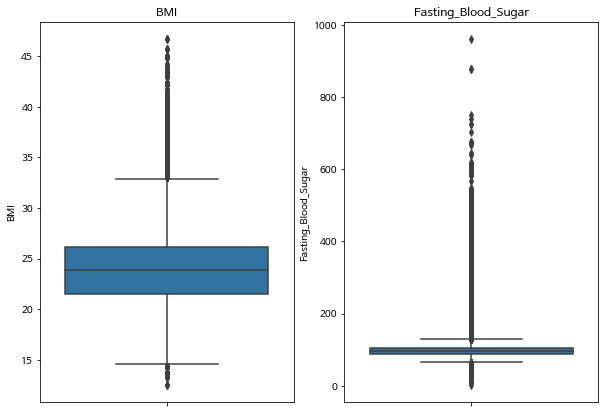

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))  

# BMI의 상자 그림을 첫번째(ax1)로 그린다. 방향은 수직(orient='v')
sns.boxplot(y= 'BMI', data=a, ax=ax1, orient='v')
ax1.set_title('BMI')

# Fasting_Blood_Sugar의 상자 그림을 두번째(ax2)로 그린다.
sns.boxplot(y= 'Fasting_Blood_Sugar', data=a, ax=ax2, orient='v')
ax2.set_title('Fasting_Blood_Sugar')

plt.show()

선형회귀분석은 독립변수와 종속변수가 정규분포를 따를 때 잘 작동한다. 밀도 플롯(density plot)을 그려서 정규분포의 형태인지 확인해본다.

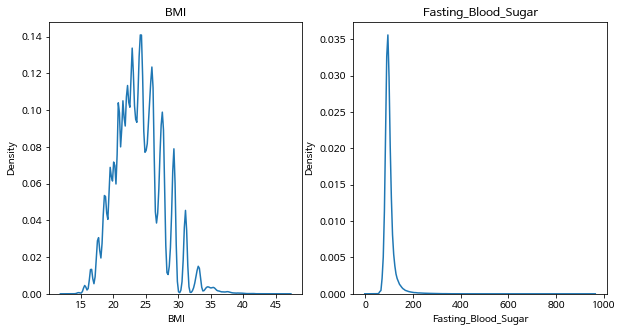

In [ ]:
# 1행 2열 형태로 2개의 그래프를 그린다
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))  

# BMI의 밀도 플롯
sns.kdeplot(a['BMI'], ax=ax1)
ax1.set_title('BMI')

# FBS의 밀도 플롯
sns.kdeplot(a['Fasting_Blood_Sugar'], ax=ax2)
ax2.set_title('Fasting_Blood_Sugar')

plt.show()

데이터가 치우친 정도를 나타내는 왜도(skewness)를 구해본다. e1071 라이브러리가 없을 경우에는 install.packages('e1071')을 실행하여 설치한다.

In [ ]:
scipy.stats.skew(a['BMI'])

0.5258787431888493

In [ ]:
scipy.stats.skew(a['Fasting_Blood_Sugar'])

4.625083190144624

## 분석

### 단순회귀

#### ols 함수로 회귀분석을 실시한다. 

종속변수 ~ 독립변수의 형태로 모형식을 쓴다. 

(수학에서는 y= f(x)처럼 종속변수를 왼쪽에, 독립변수를 오른쪽에 쓰는 것이 관습)

In [ ]:
model = ols('Fasting_Blood_Sugar ~ BMI', data=a)
res = model.fit()

In [ ]:
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     Fasting_Blood_Sugar   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                 3.443e+04
Date:                 Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                         14:05:28   Log-Likelihood:            -4.8083e+06
No. Observations:              1052215   AIC:                         9.617e+06
Df Residuals:                  1052213   BIC:                         9.617e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.8232      0.153    476.88

먼저 모형적합도를 보고한다. F 분포의 파라미터 2개와 그 때의 F 값, p-value와 유의수준의 비교를 적시한다.

Fasting_Blood_Sugar에 대하여 BMI로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의미하였다(F(1,1052213) = 3.443e+04, p < 0.05).

독립변수에 대해 보고한다.

BMI의 회귀계수는 1.1676 로, Fasting_Blood_Sugar에 대하여 유의미한 예측 변인인 것으로 나타났다(t(1052213) = 185.565, p < 0.05).

#### 절편의 고정

Intercept 의 coef 가 음수 이고, 종속변수의 값이 음수가 될 수 없을 경우
절편을 제거하여 절편을 0 으로 고정 시킨 것과 같이 만든다.

모형에서 절편을 제거한 경우 R제곱을 해석할 때 주의가 필요하다. 절편이 있는 경우와 없는 경우 계산 방식이 다르기 때문이다. 절편이 있는 경우에 R제곱은 종속변수의 분산에서 설명하는 비율을 나타내지만, 절편이 없는 경우는 종속변수의 제곱의 평균에서 설명하는 비율을 나타낸다.

In [ ]:
# res = ols('dist ~ 0 + speed', cars).fit()
# res.summary()

#### 다중공선성 확인

In [ ]:
model = ols('Fasting_Blood_Sugar ~ BMI + Gamma_GTP + Hemoglobin', data=a)
res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     Fasting_Blood_Sugar   R-squared:                       0.052
Model:                             OLS   Adj. R-squared:                  0.052
Method:                  Least Squares   F-statistic:                 1.933e+04
Date:                 Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                         14:05:36   Log-Likelihood:            -4.7970e+06
No. Observations:              1052215   AIC:                         9.594e+06
Df Residuals:                  1052211   BIC:                         9.594e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.4242      0.233    289.30

독립변수들의 이름

In [ ]:
model.exog_names

['Intercept', 'BMI', 'Gamma_GTP', 'Hemoglobin']

X의 첫번째 독립변수의 VIF를 계산

In [ ]:
variance_inflation_factor(model.exog, 1)

1.0902932579979665

한번에 모든 VIF 계산

In [ ]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,컬럼,VIF
0,BMI,1.090293
1,Gamma_GTP,1.070832
2,Hemoglobin,1.115877


#### 잔차분석

모형의 선형성

* 예측값(fitted)과 잔차(residual)의 비교
* 모든 예측값에서 잔차가 비슷하게 있어야 함(가운데 점선)
* 빨간 실선은 잔차의 추세를 나타냄
* 빨간 실선이 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라진다는 것

In [ ]:
t_df = a[['Fasting_Blood_Sugar', 'BMI']]

In [ ]:
model = ols('Fasting_Blood_Sugar ~ BMI', data=a)
res = model.fit()

In [ ]:
fitted = res.predict(t_df)
residual = t_df['Fasting_Blood_Sugar'] - fitted

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


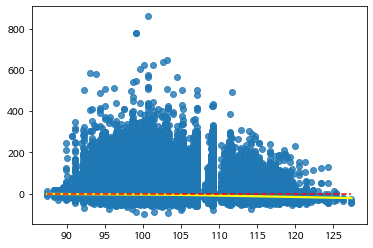

In [ ]:
sns.regplot(fitted, residual, lowess=True, line_kws={'color': 'yellow'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='red')
plt.show()

잔차의 정규성
* 잔차가 정규분포를 따른다는 가정
* Q-Q 플롯으로 확인할 수 있음
* 잔차가 정규분포를 띄면 Q-Q 플롯에서 점들이 점선을 따라 배치되어 있어야 함

In [ ]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


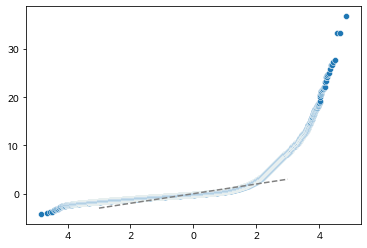

In [ ]:
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

잔차의 정규성은 샤피로 검정으로 확인할 수 있다. 아래 분석에서 두 번째 값이 p값이다. p값이 0.02이므로 유의수준 5%에서 잔차의 정규성이 위반되었다고 판단한다.

In [ ]:
scipy.stats.shapiro(residual)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6652841567993164, 0.0)

잔차의 등분산성
* 회귀모형을 통햬 예측된 값이 크던 작던, 모든 값들에 대하여 잔차의 분산이 동일하다는 가정
* 아래 그래프는 예측값(가로축)에 따라 잔차가 어떻게 달라지는지 보여줌
* 빨간색 실선이 수평선을 그리는 것이 이상적

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


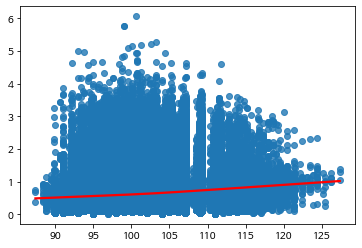

In [ ]:
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

극단값

* Cook's distance는 극단값을 나타내는 지표

In [ ]:
cd, _ = OLSInfluence(res).cooks_distance

619217 번 자료가 예측에서 많이 벗어남

In [ ]:
cd.sort_values(ascending=False).head()

608433     0.001613
961798     0.001311
1029672    0.001137
17201      0.001099
444246     0.001002
dtype: float64

잔차의 독립성
* 회귀분석에서 잔차는 정규성, 등분산성 그리고 독립성을 가지는 것으로 가정
* 자료 수집 과정에서 무작위 표집(random sampling)을 하였다면, 잔차의 독립성은 만족하는 것으로 봄
* 시계열 자료나 종단연구 자료처럼, 연구 설계 자체가 독립성을 담보할 수 없는 경우에는 더빈-왓슨 검정(Durbin-Watson test) 등을 실시

잔차 분석 결과를 바탕으로 대응

잔차 분석 결과에 따라 다양한 방식의 대응이 가능
* 극단값을 제거
* 독립변수를 추가
* 종속변수를 수학적으로 변환

위의 예에서는 619217번 자료가 극단값으로 보이고 이 때문에 잔차의 정규성이 위배되는 것으로 추측된다. 따라서 619217번 자료를 제거하고 다시 분석을 시도해볼 수 있다.